In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy import stats

# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.feature_selection import RFE, SelectPercentile
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier


# from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

import category_encoders as ce
from sklearn.metrics import SCORERS, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.display.max_columns = None

In [2]:
telco = pd.read_csv('telco_clean.csv')
telco.head(2)

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [3]:
# Hapus kolom Gender, karena nilainya tidak memengaruhi model.
# Hapus kolom Phone Service, karena nilainya ada di kolom multiple lines juga

telco2 = telco.drop(['Gender', 'PhoneService'], axis = 1)
telco2.head(2)

,SeniorCitizen,Partner,Dependents,Tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,No,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,No,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [4]:
# Cek data yang kosong

telco2.isnull().sum()

SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
# Cek nilai kolom Churn

telco2['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [6]:
le = LabelEncoder()
telco2['Churn'] = le.fit_transform(telco['Churn'])
telco2['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [7]:
X = telco2.drop("Churn", axis=1)
y = telco2["Churn"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    stratify = y, # stratified random sampling
    test_size = 0.2,
    random_state=2020)

## Base Models

Ada 2 cara yang dapat digunakan untuk mengatasi data target (y) yang imbalance:

1. Setting parameter "(class_weight='balanced')" untuk model yang memilikinya dan masing-masing "random_state" parameter.
1. Menggunakan metode SMOTE oversampling dan setting "random_state" parameter untuk model yang tidak memiliki "class_weight" parameter.

In [8]:
logreg = LogisticRegression(random_state=2020, class_weight='balanced')
dtc = DecisionTreeClassifier(random_state=2020, class_weight='balanced')
rfc = RandomForestClassifier(random_state=2020, class_weight='balanced')
xgb = XGBClassifier(random_state=2020)
knc = KNeighborsClassifier()
smote = SMOTE()

In [9]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [10]:
telco2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7043 non-null   object 
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   Tenure            7043 non-null   int64  
 4   MultipleLines     7043 non-null   object 
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  PaperlessBilling  7043 non-null   object 
 14  PaymentMethod     7043 non-null   object 
 15  MonthlyCharges    7043 non-null   float64
 16  TotalCharges      7043 non-null   float64


In [11]:
num_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']
cat_features = ['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                'Contract', 'PaperlessBilling', 'PaymentMethod']
target = 'Churn'

### Pipeline 

In [12]:
# for monthly and total charges
logreg_scale = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=1))
])

# for all object columns
logreg_pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# transforming all columns
transformer = ColumnTransformer([
    ('num', logreg_scale, ['MonthlyCharges', 'TotalCharges']),
    ('cat', logreg_pipe_cat, ['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                'Contract', 'PaperlessBilling', 'PaymentMethod'])
], remainder = 'passthrough')

#### For Logistic Regression

In [13]:
logreg_pipe_all = Pipeline([
    ('transformer', transformer),
    ('rfe', RFE(logreg)),
    ('resampling', smote),
    ('all_logreg', logreg)
])

In [14]:
rskf = RepeatedStratifiedKFold(random_state=2020)
logreg_cv = cross_val_score(logreg_pipe_all, X_train_val, y_train_val, cv = rskf, scoring='recall', verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.3s finished


In [15]:
print('CV Logistic Regression', logreg_cv)
print('CV Logistic Regression', logreg_cv.mean())

CV Logistic Regression [0.77591973 0.7826087  0.7826087  0.77926421 0.82274247 0.80267559
 0.77591973 0.77926421 0.77257525 0.80267559 0.81605351 0.77926421
 0.76588629 0.81939799 0.77591973 0.75250836 0.80936455 0.76588629
 0.7826087  0.83277592 0.75919732 0.85618729 0.7826087  0.81270903
 0.75585284 0.78595318 0.7826087  0.78929766 0.77257525 0.7993311
 0.75250836 0.7993311  0.81939799 0.79598662 0.76923077 0.76923077
 0.75585284 0.75585284 0.81605351 0.8361204  0.75250836 0.78595318
 0.76923077 0.80936455 0.80936455 0.77926421 0.7826087  0.80936455
 0.79598662 0.75585284]
CV Logistic Regression 0.7878260869565219


#### For Decision Tree Classifier

In [16]:
dtc_pipe_all = Pipeline([
    ('transformer', transformer),
    ('rfe', RFE(dtc)),
    ('resampling', smote),
    ('all_dtc', dtc)
])

In [17]:
rskf = RepeatedStratifiedKFold(random_state=2020)
dtc_cv = cross_val_score(dtc_pipe_all, X_train_val, y_train_val, cv = rskf, scoring='recall', verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.0s finished


In [18]:
print('CV Decision Tree Classifier', dtc_cv)
print('CV Decision Tree Classifier', dtc_cv.mean())

CV Decision Tree Classifier [0.56856187 0.53846154 0.48494983 0.56856187 0.55852843 0.60200669
 0.51839465 0.55518395 0.52508361 0.54180602 0.55183946 0.53511706
 0.56856187 0.52173913 0.52508361 0.52508361 0.51170569 0.45150502
 0.49832776 0.56187291 0.55852843 0.52842809 0.46822742 0.55518395
 0.54180602 0.55518395 0.51839465 0.50167224 0.56521739 0.52508361
 0.49832776 0.55852843 0.53511706 0.51505017 0.51839465 0.51505017
 0.54849498 0.55518395 0.55518395 0.53846154 0.54180602 0.52842809
 0.48160535 0.56187291 0.60200669 0.53511706 0.48494983 0.57525084
 0.56521739 0.48160535]
CV Decision Tree Classifier 0.5345150501672241


#### For Random Forest Classifier

In [19]:
rfc_pipe_all = Pipeline([
    ('transformer', transformer),
    ('rfe', RFE(rfc)),
    ('resampling', smote),
    ('all_rfc', rfc)
])

In [20]:
rskf = RepeatedStratifiedKFold(random_state=2020)
rfc_cv = cross_val_score(rfc_pipe_all, X_train_val, y_train_val, cv = rskf, scoring='recall', verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.1min finished


In [21]:
print('CV Random Forest Classifier ', rfc_cv)
print('CV Random Forest Classifier', rfc_cv.mean())

CV Random Forest Classifier  [0.56521739 0.48829431 0.47491639 0.52173913 0.55183946 0.56187291
 0.53177258 0.57190635 0.54849498 0.51170569 0.53846154 0.53177258
 0.55183946 0.56187291 0.52842809 0.54180602 0.51839465 0.44147157
 0.53511706 0.55852843 0.53511706 0.54180602 0.51170569 0.57190635
 0.55183946 0.58528428 0.53846154 0.51505017 0.56856187 0.47491639
 0.52508361 0.54849498 0.55518395 0.54180602 0.51170569 0.51505017
 0.52842809 0.53511706 0.56856187 0.57859532 0.54849498 0.56187291
 0.48494983 0.54180602 0.5819398  0.53177258 0.51505017 0.57859532
 0.55183946 0.49832776]
CV Random Forest Classifier 0.5366555183946488


#### For XGB Classifier

In [22]:
xgb_pipe_all = Pipeline([
    ('transformer', transformer),
    ('resampling', smote),
    ('rfe', RFE(xgb)),
    ('all_xgb', xgb)
])

In [23]:
rskf = RepeatedStratifiedKFold(random_state=2020)
xgb_cv = cross_val_score(xgb_pipe_all, X_train_val, y_train_val, cv = rskf, scoring='recall', verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.9min finished


In [24]:
print('CV XGB Classifier', xgb_cv)
print('CV XGB Classifier', xgb_cv.mean())

CV XGB Classifier [0.57525084 0.55518395 0.5451505  0.57190635 0.54849498 0.56856187
 0.5451505  0.60200669 0.55518395 0.55183946 0.55852843 0.55183946
 0.51839465 0.64214047 0.54180602 0.58862876 0.53846154 0.54849498
 0.53177258 0.59197324 0.54180602 0.5451505  0.55518395 0.55518395
 0.51505017 0.57190635 0.57859532 0.55183946 0.55852843 0.56187291
 0.51839465 0.5819398  0.59866221 0.57525084 0.53511706 0.5451505
 0.55183946 0.56187291 0.59866221 0.5451505  0.51505017 0.55852843
 0.50501672 0.55852843 0.55518395 0.54180602 0.60200669 0.55852843
 0.55518395 0.53846154]
CV XGB Classifier 0.5573244147157191


#### For K Neighbors Classifier

In [25]:
knc_pipe_all = Pipeline([
    ('transformer', transformer),
    ('resampling', smote),
    ('all_knc', knc)
])

In [26]:
rskf = RepeatedStratifiedKFold(random_state=2020)
knc_cv = cross_val_score(knc_pipe_all, X_train_val, y_train_val, cv = rskf, scoring='recall', verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.6s finished


In [27]:
print('CV K Nearest Classifier', knc_cv)
print('CV K Nearest Classifier', knc_cv.mean())

CV K Nearest Classifier [0.73913043 0.75919732 0.74247492 0.78929766 0.76923077 0.78595318
 0.76588629 0.73578595 0.77257525 0.72240803 0.76923077 0.76254181
 0.74247492 0.76254181 0.71906355 0.77257525 0.77591973 0.75919732
 0.79264214 0.77591973 0.71906355 0.79598662 0.75919732 0.7458194
 0.76588629 0.79598662 0.75585284 0.74247492 0.75919732 0.7458194
 0.74247492 0.75919732 0.75585284 0.82274247 0.74247492 0.73578595
 0.74247492 0.7458194  0.79598662 0.7826087  0.75585284 0.75250836
 0.71906355 0.80267559 0.78595318 0.76923077 0.76254181 0.76588629
 0.76923077 0.74247492]
CV K Nearest Classifier 0.7610033444816052


## Tune Models

### Top 3 Base Models

In [28]:
print('CV Logistic Regression', logreg_cv.mean())
print('CV XGB Classifier', xgb_cv.mean())
print('CV K Nearest Classifier', knc_cv.mean())

CV Logistic Regression 0.7878260869565219
CV XGB Classifier 0.5573244147157191
CV K Nearest Classifier 0.7610033444816052


#### For Logistic Regression

In [29]:
logreg_pipe_all_tuned = Pipeline([
    ('transformer', transformer),
    ('percen', SelectPercentile(percentile=50)),
    ('all_logreg', logreg)
])

In [30]:
rskf = RepeatedStratifiedKFold(random_state=2020)
logreg_cv_tuned = cross_val_score(logreg_pipe_all_tuned, X_train_val, y_train_val, cv = rskf, scoring='recall', verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.4s finished


In [31]:
print('CV Logistic Regression Percentile', logreg_cv_tuned)
print('CV Logistic Regression Percentile', logreg_cv_tuned.mean())
print('CV Logistic Regression Percentile', logreg_cv_tuned.min())
print('CV Logistic Regression Percentile', logreg_cv_tuned.max())
print('CV Logistic Regression Percentile', np.median(logreg_cv_tuned))

# deviasi selisih 11

CV Logistic Regression Percentile [0.78929766 0.7826087  0.78595318 0.81270903 0.81939799 0.81939799
 0.77926421 0.78929766 0.79264214 0.81939799 0.81270903 0.7826087
 0.80267559 0.83277592 0.77257525 0.7826087  0.78595318 0.7826087
 0.79598662 0.83277592 0.74916388 0.85284281 0.79598662 0.7993311
 0.77591973 0.80936455 0.80936455 0.7993311  0.81605351 0.77926421
 0.77257525 0.80602007 0.81270903 0.81270903 0.78595318 0.77591973
 0.76923077 0.79598662 0.84615385 0.82274247 0.78929766 0.80267559
 0.74916388 0.83946488 0.81605351 0.80936455 0.78929766 0.80267559
 0.81270903 0.7826087 ]
CV Logistic Regression Percentile 0.7990635451505018
CV Logistic Regression Percentile 0.7491638795986622
CV Logistic Regression Percentile 0.8528428093645485
CV Logistic Regression Percentile 0.7976588628762542


#### For Decision Tree Classifier

In [32]:
dtc_pipe_all_tuned = Pipeline([
    ('transformer', transformer),
    ('percen', SelectPercentile(percentile=50)),
    ('all_dtc', dtc)
])

In [33]:
rskf = RepeatedStratifiedKFold(random_state=2020)
dtc_cv_tuned = cross_val_score(dtc_pipe_all_tuned, X_train_val, y_train_val, cv = rskf, scoring='recall', verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.3s finished


In [34]:
print('CV Decision Tree Classifier Percentile', dtc_cv_tuned)
print('CV Decision Tree Classifier Percentile', dtc_cv_tuned.mean())
print('CV Decision Tree Classifier Percentile', dtc_cv_tuned.min())
print('CV Decision Tree Classifier Percentile', dtc_cv_tuned.max())
print('CV Decision Tree Classifier Percentile', np.median(dtc_cv_tuned))

# selisih 12

CV Decision Tree Classifier Percentile [0.73244147 0.76254181 0.74916388 0.72909699 0.7993311  0.78929766
 0.71237458 0.74247492 0.76588629 0.7826087  0.77257525 0.74916388
 0.73578595 0.77591973 0.73913043 0.72575251 0.76923077 0.71571906
 0.75919732 0.77591973 0.68561873 0.7826087  0.72240803 0.7826087
 0.71906355 0.79598662 0.76923077 0.76923077 0.77257525 0.71906355
 0.69230769 0.72575251 0.73913043 0.80602007 0.73578595 0.73913043
 0.76923077 0.75585284 0.77257525 0.7826087  0.75585284 0.72575251
 0.68896321 0.77591973 0.80936455 0.75585284 0.7993311  0.78595318
 0.76588629 0.71237458]
CV Decision Tree Classifier Percentile 0.7539130434782609
CV Decision Tree Classifier Percentile 0.68561872909699
CV Decision Tree Classifier Percentile 0.8093645484949833
CV Decision Tree Classifier Percentile 0.7575250836120402


#### For Random Forest Classifier

In [35]:
rfc_pipe_all_tuned = Pipeline([
    ('transformer', transformer),
    ('percen', SelectPercentile(percentile=50)),
    ('all_rfc', rfc)
])

In [36]:
rskf = RepeatedStratifiedKFold(random_state=2020)
rfc_cv_tuned = cross_val_score(rfc_pipe_all_tuned, X_train_val, y_train_val, cv = rskf, scoring='recall', verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.3s finished


In [37]:
print('CV Random Forest Classifier Percentile', rfc_cv_tuned)
print('CV Random Forest Classifier Percentile', rfc_cv_tuned.mean())

CV Random Forest Classifier Percentile [0.70234114 0.72240803 0.71571906 0.67892977 0.76254181 0.74916388
 0.67892977 0.68896321 0.73913043 0.74247492 0.72909699 0.72909699
 0.67558528 0.73578595 0.69899666 0.70234114 0.72240803 0.66220736
 0.72909699 0.74247492 0.65217391 0.72240803 0.69565217 0.74247492
 0.69899666 0.7458194  0.72909699 0.68896321 0.74247492 0.68896321
 0.66220736 0.6722408  0.71237458 0.76254181 0.69899666 0.68227425
 0.73578595 0.71237458 0.73913043 0.70234114 0.73578595 0.70568562
 0.62541806 0.74916388 0.74916388 0.72240803 0.76254181 0.76254181
 0.72909699 0.65886288]
CV Random Forest Classifier Percentile 0.7139130434782609


#### For XGB Classifier

In [38]:
xgb_pipe_all_tuned = Pipeline([
    ('transformer', transformer),
    ('resampling', SMOTE(random_state=2021)),
    ('percen', SelectPercentile(percentile=50)),
    ('all_xgb', xgb)
])

In [39]:
rskf = RepeatedStratifiedKFold(random_state=2020)
xgb_cv_tuned = cross_val_score(xgb_pipe_all_tuned, X_train_val, y_train_val, cv = rskf, scoring='recall', verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.9s finished


In [40]:
print('CV XGBoost Classifier Percentile', xgb_cv_tuned)
print('CV XGBoost Classifier Percentile', xgb_cv_tuned.mean())

CV XGBoost Classifier Percentile [0.63210702 0.64214047 0.62876254 0.60869565 0.65551839 0.65886288
 0.63879599 0.63210702 0.6187291  0.64214047 0.66220736 0.68227425
 0.61204013 0.66889632 0.62207358 0.66220736 0.65886288 0.59866221
 0.62541806 0.73244147 0.59866221 0.66889632 0.62876254 0.64548495
 0.63879599 0.67892977 0.64882943 0.54849498 0.69899666 0.63210702
 0.60200669 0.63210702 0.62541806 0.63545151 0.62876254 0.60535117
 0.68561873 0.63210702 0.72909699 0.64882943 0.63545151 0.65551839
 0.57859532 0.68896321 0.69565217 0.62876254 0.68561873 0.69899666
 0.62541806 0.59197324]
CV XGBoost Classifier Percentile 0.6436120401337793


#### For K Neighbors Classifier

In [41]:
knc_pipe_all_tuned = Pipeline([
    ('transformer', transformer),
    ('resampling', SMOTE(random_state=202)),
    ('perce', SelectPercentile(percentile=50)),
    ('all_knc', knc)
])

In [42]:
rskf = RepeatedStratifiedKFold(random_state=2020)
knc_cv_tuned = cross_val_score(knc_pipe_all_tuned, X_train_val, y_train_val, cv = rskf, scoring='recall', verbose = 1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.6s finished


In [43]:
print('CV K Nearest Classifier Percentile', knc_cv_tuned)
print('CV K Nearest Classifier Percentile', knc_cv_tuned.mean())

CV K Nearest Classifier Percentile [0.63210702 0.60535117 0.63879599 0.68227425 0.63879599 0.6187291
 0.61204013 0.64882943 0.69565217 0.62541806 0.70568562 0.63545151
 0.59197324 0.66555184 0.62207358 0.58528428 0.67558528 0.57525084
 0.63545151 0.65886288 0.58528428 0.63879599 0.62876254 0.65886288
 0.59197324 0.63210702 0.66220736 0.61538462 0.66220736 0.59866221
 0.55852843 0.63210702 0.62876254 0.64548495 0.62541806 0.63879599
 0.59197324 0.60200669 0.60535117 0.66889632 0.64214047 0.65551839
 0.59531773 0.63545151 0.68896321 0.6187291  0.60869565 0.6722408
 0.65551839 0.64214047]
CV K Nearest Classifier Percentile 0.6327090301003345


### Top 3 Best Tuned Models

In [44]:
print('CV Logistic Regression Percentile', logreg_cv_tuned.mean())
print('CV Decision Tree Classifier Percentile', dtc_cv_tuned.mean())
print('CV Random Forest Classifier Percentile', rfc_cv_tuned.mean())

CV Logistic Regression Percentile 0.7990635451505018
CV Decision Tree Classifier Percentile 0.7539130434782609
CV Random Forest Classifier Percentile 0.7139130434782609


RepeatedStratifiedKFold dan GridSearchCV digunakan untuk mencari nilai paramater yang terbaik. Scoring yang digunakan adalah 'recall'.

### Logistic Regression

In [45]:
logreg_pipe_all_tuned.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num',
                                    Pipeline(steps=[('scaler', RobustScaler()),
                                                    ('pca', PCA(n_components=1))]),
                                    ['MonthlyCharges', 'TotalCharges']),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['SeniorCitizen', 'Partner', 'Dependents',
                                     'MultipleLines', 'InternetService',
                                     'OnlineSecurity', 'OnlineBackup',
                                     'DeviceProtection', 'TechSupport',
                                     'StreamingTV', 'StreamingMovies', 'Contract',
                                     'PaperlessBilling', 'Pay

In [46]:
hyperparam_space = {
    'all_logreg__C':[1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001],
    'all_logreg__max_iter':[100, 200, 300, 400, 500, 1000],
    'all_logreg__penalty': ['l1', 'l2']
}

rskf = RepeatedStratifiedKFold(random_state=2020)

logreg_gridsearch = GridSearchCV(logreg_pipe_all_tuned, hyperparam_space, scoring='recall', n_jobs=-1, cv=rskf, verbose = 1 )
logreg_gridsearch.fit(X_train_val, y_train_val)

Fitting 50 folds for each of 156 candidates, totalling 7800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3588 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 6388 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 7800 out of 7800 | elapsed:  9.8min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2020),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=1))]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('cat',
              

In [47]:
logreg_gridsearch.best_params_

{'all_logreg__C': 500,
 'all_logreg__max_iter': 100,
 'all_logreg__penalty': 'l2'}

In [48]:
logreg_gridsearch.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=1))]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
          

In [49]:
cv_res_df = pd.DataFrame(logreg_gridsearch.cv_results_)
cv_res_df[cv_res_df['rank_test_score'] == 1].head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_all_logreg__C,param_all_logreg__max_iter,param_all_logreg__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
13,0.182150,0.036286,0.027791,0.012322,500,100,l2,"{'all_logreg__C': 500, 'all_logreg__max_iter':...",0.789298,0.782609,0.785953,0.812709,0.819398,0.826087,0.77592,0.795987,0.792642,0.819398,0.819398,0.785953,0.802676,0.832776,0.769231,0.782609,0.785953,0.785953,0.795987,0.832776,0.749164,0.852843,0.795987,0.799331,0.769231,0.809365,0.809365,0.799331,0.812709,0.782609,0.77592,0.80602,0.812709,0.816054,0.785953,0.779264,0.772575,0.799331,0.846154,0.822742,0.792642,0.802676,0.752508,0.839465,0.819398,0.816054,0.789298,0.802676,0.816054,0.782609,0.800067,0.022127,1
15,0.200704,0.077902,0.030585,0.013879,500,200,l2,"{'all_logreg__C': 500, 'all_logreg__max_iter':...",0.789298,0.782609,0.785953,0.812709,0.819398,0.826087,0.77592,0.795987,0.792642,0.819398,0.819398,0.785953,0.802676,0.832776,0.769231,0.782609,0.785953,0.785953,0.795987,0.832776,0.749164,0.852843,0.795987,0.799331,0.769231,0.809365,0.809365,0.799331,0.812709,0.782609,0.77592,0.80602,0.812709,0.816054,0.785953,0.779264,0.772575,0.799331,0.846154,0.822742,0.792642,0.802676,0.752508,0.839465,0.819398,0.816054,0.789298,0.802676,0.816054,0.782609,0.800067,0.022127,1
17,0.228043,0.048298,0.035135,0.011776,500,300,l2,"{'all_logreg__C': 500, 'all_logreg__max_iter':...",0.789298,0.782609,0.785953,0.812709,0.819398,0.826087,0.77592,0.795987,0.792642,0.819398,0.819398,0.785953,0.802676,0.832776,0.769231,0.782609,0.785953,0.785953,0.795987,0.832776,0.749164,0.852843,0.795987,0.799331,0.769231,0.809365,0.809365,0.799331,0.812709,0.782609,0.77592,0.80602,0.812709,0.816054,0.785953,0.779264,0.772575,0.799331,0.846154,0.822742,0.792642,0.802676,0.752508,0.839465,0.819398,0.816054,0.789298,0.802676,0.816054,0.782609,0.800067,0.022127,1
19,0.172931,0.029290,0.026376,0.006785,500,400,l2,"{'all_logreg__C': 500, 'all_logreg__max_iter':...",0.789298,0.782609,0.785953,0.812709,0.819398,0.826087,0.77592,0.795987,0.792642,0.819398,0.819398,0.785953,0.802676,0.832776,0.769231,0.782609,0.785953,0.785953,0.795987,0.832776,0.749164,0.852843,0.795987,0.799331,0.769231,0.809365,0.809365,0.799331,0.812709,0.782609,0.77592,0.80602,0.812709,0.816054,0.785953,0.779264,0.772575,0.799331,0.846154,0.822742,0.792642,0.802676,0.752508,0.839465,0.819398,0.816054,0.789298,0.802676,0.816054,0.782609,0.800067,0.022127,1
21,0.229308,0.066529,0.037329,0.022372,500,500,l2,"{'all_logreg__C': 500, 'all_logreg__max_iter':...",0.789298,0.782609,0.785953,0.812709,0.819398,0.826087,0.77592,0.795987,0.792642,0.819398,0.819398,0.785953,0.802676,0.832776,0.769231,0.782609,0.785953,0.785953,0.795987,0.832776,0.749164,0.852843,0.795987,0.799331,0.769231,0.809365,0.809365,0.799331,0.812709,0.782609,0.77592,0.80602,0.812709,0.816054,0.785953,0.779264,0.772575,0.799331,0.846154,0.822742,0.792642,0.802676,0.752508,0.839465,0.819398,0.816054,0.789298,0.802676,0.816054,0.782609,0.800067,0.022127,1


In [50]:
logreg_default = logreg_pipe_all.fit(X_train_val, y_train_val)
y_pred_logreg = logreg_default.predict(X_test) 

In [51]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1035
           1       0.49      0.77      0.60       374

    accuracy                           0.72      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.79      0.72      0.74      1409



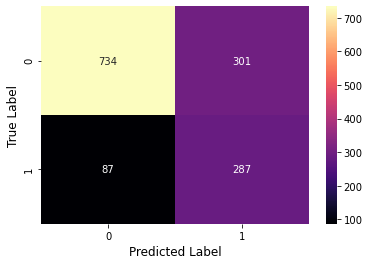

In [52]:
logreg_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(logreg_confusion_matrix, annot=True, fmt="d", cmap="magma")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [53]:
print("Pelanggan yang diprediksi tidak berhenti tapi ternyata berhenti :", round(88/(738+88)*100,2),"%")
print("Pelanggan yang diprediksi berhenti tapi ternyata tidak :", round(297/(286+297)*100,2),"%")

Pelanggan yang diprediksi tidak berhenti tapi ternyata berhenti : 10.65 %
Pelanggan yang diprediksi berhenti tapi ternyata tidak : 50.94 %


In [54]:
logreg_tuned = logreg_gridsearch.best_estimator_.fit(X_train_val, y_train_val)
y_pred_logreg_tuned = logreg_tuned.predict(X_test)

In [55]:
print(classification_report(y_test, y_pred_logreg_tuned))

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1035
           1       0.48      0.79      0.60       374

    accuracy                           0.72      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.79      0.72      0.73      1409



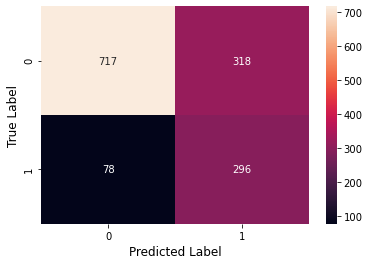

In [56]:
logreg_tuned_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_logreg_tuned)
sns.heatmap(logreg_tuned_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [57]:
print("Pelanggan yang diprediksi tidak berhenti tapi ternyata berhenti :", round(78/(717+78)*100,2),"%")
print("Pelanggan yang diprediksi berhenti tapi ternyata tidak :", round(318/(296+318)*100,2),"%")

Pelanggan yang diprediksi tidak berhenti tapi ternyata berhenti : 9.81 %
Pelanggan yang diprediksi berhenti tapi ternyata tidak : 51.79 %


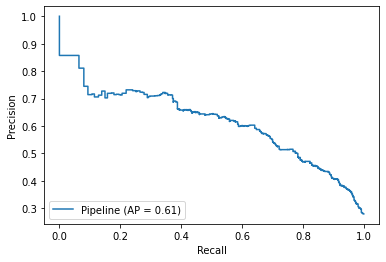

In [58]:
plot_precision_recall_curve(logreg_tuned, X_test, y_test)

### Decision Tree

In [59]:
dtc_pipe_all_tuned.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num',
                                    Pipeline(steps=[('scaler', RobustScaler()),
                                                    ('pca', PCA(n_components=1))]),
                                    ['MonthlyCharges', 'TotalCharges']),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['SeniorCitizen', 'Partner', 'Dependents',
                                     'MultipleLines', 'InternetService',
                                     'OnlineSecurity', 'OnlineBackup',
                                     'DeviceProtection', 'TechSupport',
                                     'StreamingTV', 'StreamingMovies', 'Contract',
                                     'PaperlessBilling', 'Pay

In [60]:
hyperparam_space = {
    'all_dtc__min_samples_split': [4,5,6,7,8,9,10],
    'all_dtc__max_depth': [2,3,4,5,6,7],
    'all_dtc__criterion': ['entropy', 'gini']  
}

rskf = RepeatedStratifiedKFold(random_state=2020)

dtc_gridsearch = GridSearchCV(dtc_pipe_all_tuned, hyperparam_space, scoring='recall', n_jobs=-1, cv=rskf, verbose = 1)
dtc_gridsearch.fit(X_train_val, y_train_val)

Fitting 50 folds for each of 84 candidates, totalling 4200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3588 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:  4.4min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=2020),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          RobustScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=1))]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('cat',
              

In [61]:
dtc_gridsearch.best_params_

{'all_dtc__criterion': 'entropy',
 'all_dtc__max_depth': 3,
 'all_dtc__min_samples_split': 4}

In [62]:
dtc_gridsearch.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=1))]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
          

In [63]:
cv_res_df = pd.DataFrame(dtc_gridsearch.cv_results_)
cv_res_df[cv_res_df['rank_test_score'] == 1].head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_all_dtc__criterion,param_all_dtc__max_depth,param_all_dtc__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
7,0.088563,0.017830,0.025175,0.006260,entropy,3,4,"{'all_dtc__criterion': 'entropy', 'all_dtc__ma...",0.87291,0.909699,0.87291,0.889632,0.923077,0.916388,0.862876,0.882943,0.896321,0.909699,0.889632,0.866221,0.892977,0.919732,0.899666,0.876254,0.886288,0.862876,0.882943,0.923077,0.849498,0.913043,0.886288,0.909699,0.856187,0.899666,0.913043,0.896321,0.892977,0.866221,0.876254,0.892977,0.923077,0.90301,0.866221,0.846154,0.869565,0.916388,0.929766,0.906355,0.876254,0.886288,0.879599,0.919732,0.906355,0.899666,0.90301,0.889632,0.896321,0.879599,0.891706,0.020594,1
8,0.078880,0.009074,0.025128,0.004524,entropy,3,5,"{'all_dtc__criterion': 'entropy', 'all_dtc__ma...",0.87291,0.909699,0.87291,0.889632,0.923077,0.916388,0.862876,0.882943,0.896321,0.909699,0.889632,0.866221,0.892977,0.919732,0.899666,0.876254,0.886288,0.862876,0.882943,0.923077,0.849498,0.913043,0.886288,0.909699,0.856187,0.899666,0.913043,0.896321,0.892977,0.866221,0.876254,0.892977,0.923077,0.90301,0.866221,0.846154,0.869565,0.916388,0.929766,0.906355,0.876254,0.886288,0.879599,0.919732,0.906355,0.899666,0.90301,0.889632,0.896321,0.879599,0.891706,0.020594,1
9,0.084223,0.012787,0.025156,0.004603,entropy,3,6,"{'all_dtc__criterion': 'entropy', 'all_dtc__ma...",0.87291,0.909699,0.87291,0.889632,0.923077,0.916388,0.862876,0.882943,0.896321,0.909699,0.889632,0.866221,0.892977,0.919732,0.899666,0.876254,0.886288,0.862876,0.882943,0.923077,0.849498,0.913043,0.886288,0.909699,0.856187,0.899666,0.913043,0.896321,0.892977,0.866221,0.876254,0.892977,0.923077,0.90301,0.866221,0.846154,0.869565,0.916388,0.929766,0.906355,0.876254,0.886288,0.879599,0.919732,0.906355,0.899666,0.90301,0.889632,0.896321,0.879599,0.891706,0.020594,1
10,0.079504,0.010302,0.024294,0.004061,entropy,3,7,"{'all_dtc__criterion': 'entropy', 'all_dtc__ma...",0.87291,0.909699,0.87291,0.889632,0.923077,0.916388,0.862876,0.882943,0.896321,0.909699,0.889632,0.866221,0.892977,0.919732,0.899666,0.876254,0.886288,0.862876,0.882943,0.923077,0.849498,0.913043,0.886288,0.909699,0.856187,0.899666,0.913043,0.896321,0.892977,0.866221,0.876254,0.892977,0.923077,0.90301,0.866221,0.846154,0.869565,0.916388,0.929766,0.906355,0.876254,0.886288,0.879599,0.919732,0.906355,0.899666,0.90301,0.889632,0.896321,0.879599,0.891706,0.020594,1
11,0.078597,0.008479,0.026482,0.006861,entropy,3,8,"{'all_dtc__criterion': 'entropy', 'all_dtc__ma...",0.87291,0.909699,0.87291,0.889632,0.923077,0.916388,0.862876,0.882943,0.896321,0.909699,0.889632,0.866221,0.892977,0.919732,0.899666,0.876254,0.886288,0.862876,0.882943,0.923077,0.849498,0.913043,0.886288,0.909699,0.856187,0.899666,0.913043,0.896321,0.892977,0.866221,0.876254,0.892977,0.923077,0.90301,0.866221,0.846154,0.869565,0.916388,0.929766,0.906355,0.876254,0.886288,0.879599,0.919732,0.906355,0.899666,0.90301,0.889632,0.896321,0.879599,0.891706,0.020594,1


In [64]:
dtc_default = dtc_pipe_all.fit(X_train_val, y_train_val)
y_pred_dtc = dtc_default.predict(X_test) 

In [65]:
print(classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1035
           1       0.47      0.54      0.50       374

    accuracy                           0.72      1409
   macro avg       0.65      0.66      0.65      1409
weighted avg       0.73      0.72      0.72      1409



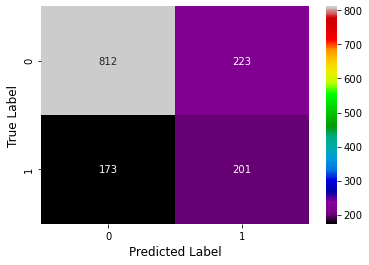

In [66]:
dtc_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_dtc)
sns.heatmap(dtc_confusion_matrix, annot=True, fmt="d", cmap="nipy_spectral")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

# plt.savefig('dtc.png', dpi=75, bbox_inches='tight')
plt.show()

In [67]:
print("Pelanggan yang diprediksi tidak berhenti tapi ternyata berhenti :", round(195/(851+195)*100,2),"%")
print("Pelanggan yang diprediksi berhenti tapi ternyata tidak :", round(184/(179+184)*100,2),"%")

Pelanggan yang diprediksi tidak berhenti tapi ternyata berhenti : 18.64 %
Pelanggan yang diprediksi berhenti tapi ternyata tidak : 50.69 %


In [68]:
dtc_tuned = dtc_gridsearch.best_estimator_.fit(X_train_val, y_train_val)
y_pred_dtc_tuned = dtc_tuned.predict(X_test)

In [69]:
print(classification_report(y_test, y_pred_dtc_tuned))

              precision    recall  f1-score   support

           0       0.91      0.57      0.70      1035
           1       0.42      0.85      0.56       374

    accuracy                           0.64      1409
   macro avg       0.67      0.71      0.63      1409
weighted avg       0.78      0.64      0.66      1409



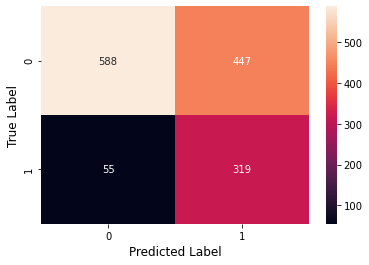

In [70]:
dtc_tuned_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_dtc_tuned)
sns.heatmap(dtc_tuned_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

# plt.savefig('dtc_tuned.png', dpi=75, bbox_inches='tight')
plt.show()

In [71]:
print("Pelanggan yang diprediksi tidak berhenti tapi ternyata berhenti :", round(55/(588+55)*100,2),"%")
print("Pelanggan yang diprediksi berhenti tapi ternyata tidak :", round(447/(319+447)*100,2),"%")

Pelanggan yang diprediksi tidak berhenti tapi ternyata berhenti : 8.55 %
Pelanggan yang diprediksi berhenti tapi ternyata tidak : 58.36 %


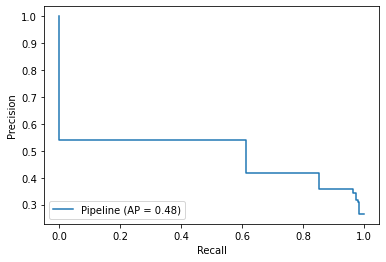

In [72]:
plot_precision_recall_curve(dtc_tuned, X_test, y_test)

#### Random Forest

In [73]:
rfc_pipe_all_tuned.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num',
                                    Pipeline(steps=[('scaler', RobustScaler()),
                                                    ('pca', PCA(n_components=1))]),
                                    ['MonthlyCharges', 'TotalCharges']),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['SeniorCitizen', 'Partner', 'Dependents',
                                     'MultipleLines', 'InternetService',
                                     'OnlineSecurity', 'OnlineBackup',
                                     'DeviceProtection', 'TechSupport',
                                     'StreamingTV', 'StreamingMovies', 'Contract',
                                     'PaperlessBilling', 'Pay

In [ ]:
hyperparam_space = {
    'all_rfc__min_samples_split': [4,5,6,7,8,9,10],
    'all_rfc__max_depth': [2,3,4,5,6,7],
    'all_rfc__criterion': ['entropy', 'gini']  
}

rskf = RepeatedStratifiedKFold(random_state=2020) # cukup skf

rfc_gridsearch = GridSearchCV(rfc_pipe_all_tuned, hyperparam_space, scoring='recall', n_jobs=-1, cv=rskf, verbose = 1)
rfc_gridsearch.fit(X_train_val, y_train_val)

Fitting 50 folds for each of 84 candidates, totalling 4200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 19.3min


In [ ]:
rfc_gridsearch.best_params_

In [ ]:
rfc_gridsearch.best_estimator_

In [ ]:
cv_res_df = pd.DataFrame(rfc_gridsearch.cv_results_)
cv_res_df[cv_res_df['rank_test_score'] == 1].head()

In [ ]:
rfc_default = rfc_pipe_all.fit(X_train_val, y_train_val)
y_pred_rfc = rfc_default.predict(X_test) 

In [ ]:
print(classification_report(y_test, y_pred_rfc))

In [ ]:
rfc_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(rfc_confusion_matrix, annot=True, fmt="d", cmap="nipy_spectral")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print("Pelanggan yang diprediksi tidak berhenti tapi ternyata berhenti :", round(183/(871+183)*100,2),"%")
print("Pelanggan yang diprediksi berhenti tapi ternyata tidak :", round(164/(191+164)*100,2),"%")

In [ ]:
rfc_tuned = rfc_gridsearch.best_estimator_.fit(X_train_val, y_train_val)
y_pred_rfc_tuned = rfc_tuned.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_rfc_tuned))

In [ ]:
rfc_tuned_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rfc_tuned)
sns.heatmap(rfc_tuned_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print("Pelanggan yang diprediksi tidak berhenti tapi ternyata berhenti :", round(64/(678+64)*100,2),"%")
print("Pelanggan yang diprediksi berhenti tapi ternyata tidak :", round(357/(310+357)*100,2),"%")

In [ ]:
plot_precision_recall_curve(rfc_tuned, X_test, y_test) 

## Kesimpulan

In [ ]:
dct_con = dtc_tuned.predict(X_test)

con = pd.DataFrame(data=confusion_matrix(y_test, dct_con), 
                   columns=['P No', 'P Yes'],
                   index = ['A No', 'A Yes']);
print(con)

Berdasarkan hasil confusion matrix dan waktu perhitungan, kita dapati bahwa performa terbaik terdapat dalam model Decision Tree Classifier. Setelah dilakukan hyperparameter tuning pada model, 'recall' score bertambah drastis, yaitu dari 0.48 menjadi 0.85

Model machine learning yang dikembangkan dapat membantu perusahaan untuk menurunkan biaya dan waktu dalam memprediksi pelanggan mana yang akan berhenti. Sebagaimana disebutkan pada bagian problem stetment, fokus kita adalah false negative rate. Dimana kita ketahui sebelumnya bahwa, biaya yang dikeuarkan untuk memperoleh pelanggan 5 kali lebih besar dari biaya mempertahankan pelanggan yang sudah ada.

Dapat kita simpulkan, dari 100 pelanggan yang diteliti, machine learning hanya menghasilkan kesalahan berjumlah 9 pelanggan atau 8,55%. Artinya 9 pelanggan tersebut tidak akan mendapat perlakuan khusus dari perusahaan dan akan berhenti berlangganan. Terdapat peningkatan dari model sebelumnya sebelum dituning, yakni dari 100 pelanggan yang diteliti, kesalahan prediksi mencapai 19 orang atau 18,64%.

Namun, yang perlu diingat juga bahwa terdapat konsekuensi lain. Yakni dari 100 pelanggan yang diprediksi akan berhenti berlangganan, ternyata 58,36% nya, atau 59 orang akan mendapatkan perlakuan khusus, tapi ternyata mereka tidak ada kecenderungan untuk churn dan akan tetap berlangganan. Jika dibandingkan model sebelumnya juga terdapat peningkatan dari 50.69% atau hanya 51 orang.